# 50.データの入手・整形

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,classification_report
from sklearn.model_selection import GridSearchCV

In [42]:
import pandas as pd
col_names = ('id','title','url','publisher','category','entertainment','story','hostname','timestamp')
df = pd.read_table('newsCorpora.csv',names = ('id','title','url','publisher','category','entertainment','story','hostname','timestamp'), index_col = 0)
df = df[df['publisher'].isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"])][['category','title']]

In [43]:
df_train,df_test = train_test_split(df, train_size = 0.8)
df_test,df_valid = train_test_split(df_test, train_size = 0.5)

df_train.to_csv("train.txt",sep="\t", index = False)
df_valid.to_csv("valid.txt",sep="\t", index = False)
df_test.to_csv("test.txt" ,sep ="\t", index = False)

In [44]:
print(df_train['category'].value_counts())
print(df_valid['category'].value_counts())
print(df_test['category'].value_counts())

b    4500
e    4218
t    1225
m     729
Name: category, dtype: int64
b    572
e    522
t    152
m     88
Name: category, dtype: int64
b    555
e    539
t    147
m     93
Name: category, dtype: int64


# 51.特徴量抽出

In [45]:
tfidf = TfidfVectorizer()
#x = tfidf.fit_transform()

train_tfidf = tfidf.fit_transform(df_train['title'])
test_tfidf = tfidf.transform(df_test['title'])
valid_tfidf = tfidf.transform(df_valid['title'])


train_feature = pd.DataFrame(train_tfidf.toarray(), columns=tfidf.get_feature_names())
train_feature.to_csv("train.feature.txt", sep="\t", index=False)
test_feature = pd.DataFrame(test_tfidf.toarray(), columns=tfidf.get_feature_names())
test_feature.to_csv("test.feature.txt", sep="\t", index=False)
valid_feature = pd.DataFrame(valid_tfidf.toarray(), columns=tfidf.get_feature_names())
valid_feature.to_csv("valid.feature.txt", sep="\t", index=False)

# 52.学習

In [46]:
model = LogisticRegression(max_iter=300)
model.fit(train_feature,df_train['category'])

LogisticRegression(max_iter=300)

# 53.予測

In [47]:
pre = model.predict(valid_feature)
pre_ = model.predict_proba(valid_feature)
for i in range(10):
    print('{}\t{}'.format(pre[i],pre_[i]))

e	[0.10760348 0.78020026 0.05534911 0.05684715]
t	[0.13099064 0.27035402 0.06694354 0.53171181]
b	[0.84890702 0.08492066 0.02555143 0.04062089]
b	[0.95248324 0.02379473 0.00768947 0.01603256]
b	[0.98285999 0.00776043 0.00340982 0.00596976]
e	[0.07195153 0.88576472 0.02324952 0.01903423]
e	[0.11501611 0.79737039 0.03655542 0.05105808]
t	[0.33025115 0.10938469 0.02793478 0.53242938]
e	[0.13293617 0.77733167 0.03694981 0.05278235]
t	[0.17060719 0.20540066 0.04553019 0.57846196]


# 54.正解率の計測

In [48]:
pre = model.predict(train_feature)
print('train')
print(accuracy_score(df_train['category'],pre))
pre = model.predict(test_feature)
print('test')
print(accuracy_score(df_test['category'],pre))

train
0.9450899550224887
test
0.8778110944527736


# 55.混合行列の作成

In [49]:
pre_train = model.predict(train_feature)
print('train')
cm_train = confusion_matrix(df_train['category'],pre_train)
print(cm_train)
pre_test = model.predict(valid_feature)
print('test')
cm_test = confusion_matrix(df_test['category'],pre_test)
print(cm_test)

train
[[4409   55    3   33]
 [  17 4197    1    3]
 [  80  125  522    2]
 [ 157  108    2  958]]
test
[[235 245  19  56]
 [254 235  20  30]
 [ 43  43   2   5]
 [ 67  63   4  13]]


# 56.適合率, 再現率, F1スコアの計測

In [50]:
print('train')
print(classification_report(df_train['category'],pre_train))
print('test')
print(classification_report(df_test['category'],pre_test))

train
              precision    recall  f1-score   support

           b       0.95      0.98      0.96      4500
           e       0.94      1.00      0.96      4218
           m       0.99      0.72      0.83       729
           t       0.96      0.78      0.86      1225

    accuracy                           0.95     10672
   macro avg       0.96      0.87      0.91     10672
weighted avg       0.95      0.95      0.94     10672

test
              precision    recall  f1-score   support

           b       0.39      0.42      0.41       555
           e       0.40      0.44      0.42       539
           m       0.04      0.02      0.03        93
           t       0.12      0.09      0.10       147

    accuracy                           0.36      1334
   macro avg       0.24      0.24      0.24      1334
weighted avg       0.34      0.36      0.35      1334



# 57.特徴量の重みの確認

In [51]:
import numpy as np

names = tfidf.get_feature_names()
for category, i in zip(model.classes_, model.coef_):
    print(category)
    rank = np.argsort(i)
   
    top = [names[k] for k in rank[-10:]]
    worst = [names[k] for k in rank[:10]]
    print('top')
    print(top)
    print('worst')
    print(worst)

b
top
['dollar', 'update', 'ukraine', 'profit', 'euro', 'bank', 'ecb', 'stocks', 'china', 'fed']
worst
['the', 'and', 'her', 'ebola', 'she', 'study', 'apple', 'star', 'facebook', 'kardashian']
e
top
['movie', 'paul', 'cyrus', 'miley', 'star', 'she', 'kim', 'chris', 'her', 'kardashian']
worst
['update', 'us', 'google', 'china', 'ceo', 'gm', 'says', 'apple', 'study', 'facebook']
m
top
['virus', 'cigarettes', 'cdc', 'health', 'mers', 'fda', 'drug', 'cancer', 'study', 'ebola']
worst
['google', 'at', 'ceo', 'gm', 'facebook', 'apple', 'twitter', 'sales', 'climate', 'amazon']
t
top
['comcast', 'samsung', 'nasa', 'tesla', 'gm', 'microsoft', 'climate', 'facebook', 'apple', 'google']
worst
['stocks', 'fed', 'drug', 'american', 'cancer', 'her', 'ecb', 'percent', 'kardashian', 'ebola']


# 58.正規化パラメータの変更

In [52]:
param = [0.1, 1, 3, 5]

train_accuracy = []
test_accuracy  = []
valid_accuracy = []

for c in param:
    model = LogisticRegression(max_iter=200,C=c)
    model.fit(train_feature,df_train['category'])
    pre = model.predict(train_feature)
    train_accuracy.append(accuracy_score(df_train['category'],pre))
    pre = model.predict(test_feature)
    test_accuracy.append(accuracy_score(df_test['category'],pre))
    pre = model.predict(valid_feature)
    valid_accuracy.append(accuracy_score(df_valid['category'],pre))


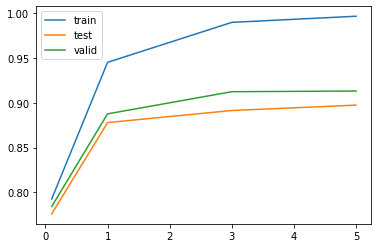

In [53]:
import matplotlib.pyplot as plt

plt.plot(param, train_accuracy,label = 'train')
plt.plot(param, test_accuracy, label = 'test')
plt.plot(param, valid_accuracy,label = 'valid')
plt.legend()

# 59.ハイパーパラメータの探索

In [54]:
C = np.logspace(0, 4, 5, base=2)
solver = ['newton-cg', 'lbfgs', 'liblinear','saga']

res = []
for c in C:
    for s in solver:
        
       model = LogisticRegression(C=c, solver=s, max_iter=600)
       model.fit(train_feature,df_train['category'])
       pre = model.predict(valid_feature)       
       res.append((accuracy_score(df_valid['category'],pre),c,s))

In [55]:
res = sorted(res, key = lambda x:x[0],reverse = True)
res[0]

(0.9152923538230885, 16.0, 'liblinear')